In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt, colors, cm, rcParams
import numpy as np
import sys
import pathlib
import os
import pwd
user = pwd.getpwuid(os.getuid())[0]
sys.path.append(rf"/home/{user}/picongpu/lib/python")
from picongpu.plugins.data import EnergyHistogramData
import figformat

fig_width, fig_height, params = figformat.figure_format(fig_width=3.4)
rcParams.update(params)

import prepic_density as den

In [2]:
species = 'e' 
p = "/media/ong/WORKDIR2/betatron0009/"
# Read histogram data
eh_data = EnergyHistogramData(p)
iterations = eh_data.get_iterations(species=species)
dist, en, iteration, dt = eh_data._get_for_iteration(
    species=species, 
    iteration=0)
div = en[1] - en[0] 
n_points_x = iterations.shape[0]
n_points_y = en.shape[0]

start_x = iterations[0]*dt*3e8*1e6
end_x = iterations[n_points_x-1]*dt*3e8*1e6
start_y = en[0]/1000
end_y = en[n_points_y-1]/1000
x = np.linspace(start_x, end_x, n_points_x, endpoint=True)
y = np.linspace(start_y, end_y, n_points_y, endpoint=True)
array2D = np.zeros((n_points_x, n_points_y))
X, Y = np.meshgrid(x, y)
extent = np.min(X), np.max(X), np.min(Y), np.max(Y)

for i in range(0,n_points_x,1):
    iteration = iterations[i]
    dist, en, iteration, dt = eh_data._get_for_iteration(
            species=species, iteration=iteration)
    array2D[i,:] = dist[:] 
div = en[1] - en[0]    
array2D = array2D/div*1.6e-19*1e12*1000 # convert to pC/MeV

In [6]:
ne = 7.4  # electron plasma density in 10^18 cm$^{-3}$
gasPower = 2
#  lengths in microns
flat_top_dist = 1000  # plasma flat top distance
gasCenterLeft_SI = 1000
gasCenterRight_SI = gasCenterLeft_SI + flat_top_dist
gasSigmaLeft_SI = 500
gasSigmaRight_SI = 500

all_x = np.linspace(0, gasCenterRight_SI + 2 * gasSigmaRight_SI, 3001)
dens = den.dens_func(
        all_x,
        center_left=gasCenterLeft_SI,
        center_right=gasCenterRight_SI,
        sigma_left=gasSigmaLeft_SI,
        sigma_right=gasSigmaRight_SI,
        power=gasPower,
    )

<IPython.core.display.Javascript object>


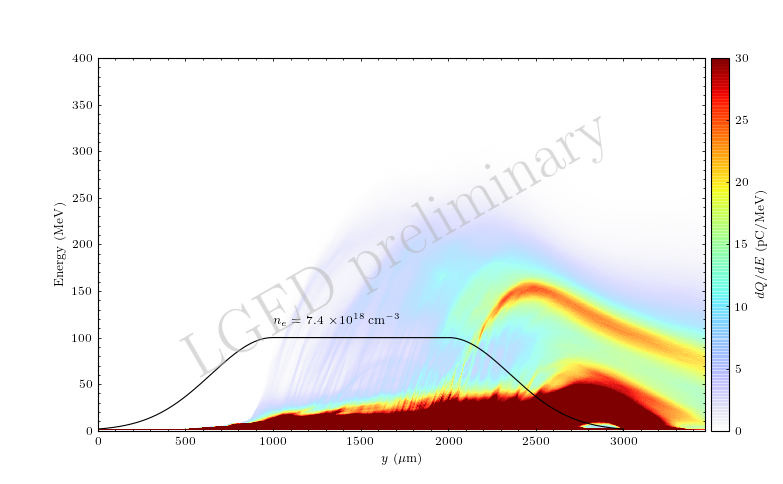

In [10]:
import custom_colormap as cc
cc.colormap_alpha('jet')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots()
img = ax.imshow(array2D.T,
                origin='lower',
                vmin=0,vmax=30,
                extent=extent,
                aspect='auto',
                cmap='jet_alpha',
                interpolation='nearest')
cbaxes = inset_axes(ax,
                width="3%",  
                height="100%",  
                loc=2,
                bbox_to_anchor=(1.01, 0., 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0)    
cbar = fig.colorbar(mappable=img, 
                orientation="vertical",
                ticklocation='right',
                cax=cbaxes)
cbar.set_label(r"$dQ/dE~(\mathrm{pC/MeV})$")
ax.plot(all_x, dens*0.25*Y.max(), color="black")
ax.text(gasCenterLeft_SI, 0.28*Y.max(),
       r"$n_e=$ %s $\times 10^{18} \; \mathrm{cm^{-3}}$" % ne)
ax.set_ylim(ymin=0)
ax.set_ylabel(r'$\mathrm{Energy}~(\mathrm{MeV})$')
ax.set_xlabel(r'$y~(\mathrm{\mu m})$')
ax.minorticks_on()
# add watermark
ax.text(0.5, 0.5, 'LGED preliminary', transform=ax.transAxes,
    fontsize=40, color='0.7', alpha=0.5,
    ha='center', va='center', rotation='30')

fig.savefig(
    f"{p}/time_slice.png",
    dpi=600,
    transparent=False,
    bbox_inches="tight")
plt.show()